In [ ]:
import os
import json
import cv2
import numpy as np
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt
from torchvision import models
from pycocotools.coco import COCO
import kagglehub
from sklearn.metrics import f1_score, confusion_matrix

# Download dataset using kagglehub
path = kagglehub.dataset_download("awsaf49/coco-2017-dataset")
dataset_path = os.path.join(path, 'coco2017')
print("Updated dataset_path:", dataset_path)

# Check if CUDA is available for faster processing
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Verify dataset structure
def verify_dataset_structure(dataset_path):
    annotations_dir = os.path.join(dataset_path, 'annotations')
    if not os.path.exists(annotations_dir):
        print(f"No annotations directory found at {annotations_dir}. Please verify the dataset structure.")
        print("Contents of dataset_path:", os.listdir(dataset_path))
        return False
    else:
        print(f"Annotations directory found at {annotations_dir}.")
        print("Contents of annotations directory:", os.listdir(annotations_dir))
        return True

# Load COCO annotations
def load_annotations(annotations_path):
    if not os.path.exists(annotations_path):
        print(f"Annotations file not found at {annotations_path}. Please ensure the file is present.")
        return None
    coco = COCO(annotations_path)
    return coco

# Load image and annotations
def load_image_and_annotations(img_id, coco, dataset_path):
    img_info = coco.loadImgs([img_id])[0]
    img_filename = img_info['file_name']
    img_path = os.path.join(dataset_path, 'train2017', img_filename)

    if not os.path.exists(img_path):
        print(f"Image file not found at {img_path}.")
        return None, None

    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    ann_ids = coco.getAnnIds(imgIds=[img_id])
    annotations = coco.loadAnns(ann_ids)

    return image, annotations

# Load and apply segmentation model
def segment_image(image):
    model = models.segmentation.deeplabv3_resnet101(weights='DEFAULT').to(device).eval()
    preprocess = T.Compose([
        T.ToPILImage(),
        T.Resize((520, 520)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    input_tensor = preprocess(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)['out'][0]
        output_predictions = output.argmax(0).byte().cpu().numpy()

    return output_predictions

# Calculate pixel accuracy, IoU, and F1 score
def calculate_metrics(pred_mask, true_mask):
    true_mask_resized = cv2.resize(true_mask, (pred_mask.shape[1], pred_mask.shape[0]), interpolation=cv2.INTER_NEAREST)

    intersection = np.logical_and(pred_mask, true_mask_resized)
    union = np.logical_or(pred_mask, true_mask_resized)

    iou_score = np.sum(intersection) / np.sum(union) if np.sum(union) != 0 else 0
    pixel_accuracy = np.sum(pred_mask == true_mask_resized) / true_mask_resized.size

    pred_mask_flat = pred_mask.flatten()
    true_mask_flat = true_mask_resized.flatten()

    f1 = f1_score(true_mask_flat, pred_mask_flat, average='macro', zero_division=1)

    return pixel_accuracy, iou_score, f1

# Main function
def main():
    annotations_path = os.path.join(dataset_path, 'annotations', 'instances_train2017.json')

    if not verify_dataset_structure(dataset_path):
        return

    coco = load_annotations(annotations_path)
    if coco is None:
        return

    img_id = coco.getImgIds()[0]  # Change this ID to test different images
    image, annotations = load_image_and_annotations(img_id, coco, dataset_path)

    if image is not None and annotations is not None:
        pred_mask = segment_image(image)

        true_mask = np.zeros(image.shape[:2], dtype=np.uint8)
        for ann in annotations:
            mask = coco.annToMask(ann)
            true_mask = np.maximum(true_mask, mask)

        pixel_accuracy, iou_score, f1_score_value = calculate_metrics(pred_mask, true_mask)

        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.title("Original Image")
        plt.imshow(image)

        plt.subplot(1, 3, 2)
        plt.title("Predicted Segmentation")
        plt.imshow(pred_mask, cmap='gray')

        plt.subplot(1, 3, 3)
        plt.title("True Mask (Resized)")
        plt.imshow(true_mask, cmap='gray')

        plt.show()

        print(f"Results for {os.path.join(dataset_path, 'train2017', coco.loadImgs([img_id])[0]['file_name'])}:")
        print(f"IoU: {iou_score:.4f}")
        print(f"Pixel Accuracy: {pixel_accuracy:.4f}")
        print(f"F1 Score: {f1_score_value:.4f}")

if __name__ == "__main__":
    main()


Annotations directory found at /root/.cache/kagglehub/datasets/awsaf49/coco-2017-dataset/versions/2/coco2017/annotations.
loading annotations into memory...
Done (t=24.70s)
creating index...
index created!
Selected image ID 281194 for category 18: 000000281194.jpg

Evaluation Metrics:
Pixel Accuracy: 0.8890
IoU: 0.0960
F1 Score: 0.0775
MSE: 1.7389


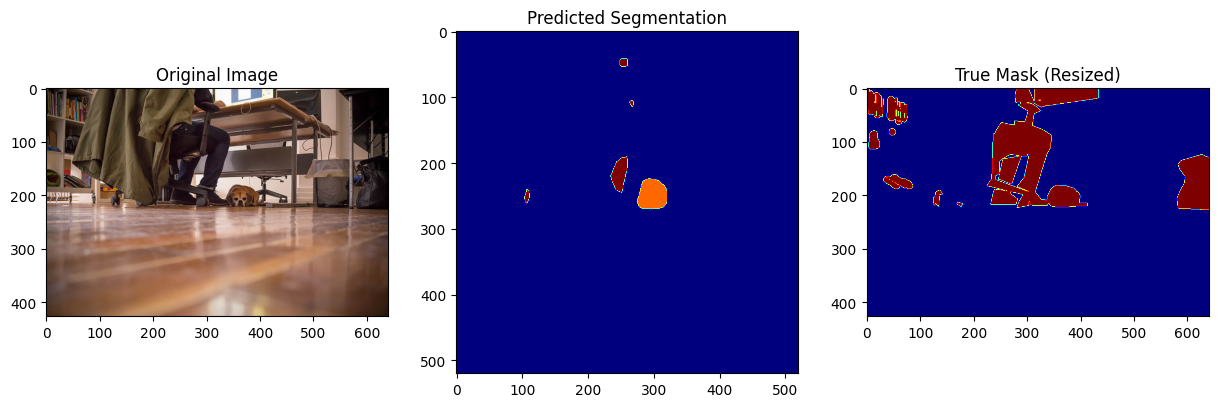